In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 

from xgboost import XGBClassifier

# import own modules
sys.path.append("..")  # Adds higher directory to python modules path.
from scripts import features as ft
from scripts import preprocessing as pp
from scripts import evaluate_models as em

#plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

import pickle


from sklearn.ensemble import VotingClassifier


### Import full dataset

In [2]:
# path to csv file
path_df = os.path.join("..", "data", "df_deep_sam.csv")

# get features - or recalculate
recalculate_df = False
if os.path.isfile(path_df) and not recalculate_df:
    df = pd.read_csv(path_df)
else:
    df = ft.get_features()
    df.to_csv(path_df, index=False)

# set id as index
df = df.set_index("id", drop=True)

# drop first batch of useless variables
df = df.drop(columns=['img', 'sp_idx'])
df = df.drop(columns=[col for col in df.columns if "_obj" in col])  # drop 'object' columns

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

df = df[df["sp_fix_duration_ms_total"] <= 5000]

 -> dataframe has 7598 instances and 44 columns
 -> there are 44 numerical columns
 -> there are 0 categoricals columns


In [3]:
df.columns

Index(['asd', 'sp_fix_count', 'sp_fix_duration_ms_total',
       'sp_fix_duration_ms_mean', 'sp_fix_duration_ms_var', 'sp_len_px_total',
       'sp_saccade_amplitude_px_mean', 'sp_saccade_amplitude_px_var',
       'sp_distance_to_centre_px_mean', 'sp_distance_to_centre_px_var',
       'sp_distance_to_sp_mean_px_mean', 'sp_distance_to_sp_mean_px_var',
       'dg_sal_first_fixation', 'dg_sal_first_above_0.75*max_rank',
       'dg_sal_first_above_0.9*max_rank', 'dg_sal_mean', 'dg_sal_sum',
       'dg_sal_max', 'dg_sal_weighted_duration_sum',
       'dg_sal_weighted_duration_mean', 'dg_sal_KLD', 'dg_sal_NSS',
       'obj_n_fix_face', 'obj_t_abs_on_face', 'obj_t_rel_on_face',
       'obj_n_fix_animate', 'obj_n_fix_inanimate', 'obj_n_fix_background',
       'obj_t_abs_on_animate', 'obj_t_abs_on_inanimate',
       'obj_t_abs_on_background', 'obj_t_rel_on_animate',
       'obj_t_rel_on_inanimate', 'obj_t_rel_on_background',
       'sam_sal_first_fixation', 'sam_sal_first_above_0.75*max_rank',


### Select features according to each model/ do train-test split

In [4]:
# define features
feat_xgb = ['sp_fix_count', 'sp_fix_duration_ms_var', 'sp_len_px_total',
       'sp_saccade_amplitude_px_mean', 'sp_saccade_amplitude_px_var',
       'sp_distance_to_centre_px_mean', 'sp_distance_to_centre_px_var',
       'sp_distance_to_sp_mean_px_mean', 'sp_distance_to_sp_mean_px_var',
       'dg_sal_first_fixation', 'dg_sal_sum', 'dg_sal_max', 'dg_sal_weighted_duration_sum',
       'dg_sal_weighted_duration_mean', 'dg_sal_KLD', 'dg_sal_NSS', 'obj_t_abs_on_face',
       'obj_t_rel_on_face', 'obj_t_abs_on_animate', 'obj_t_abs_on_inanimate',
       'obj_t_abs_on_background', 'obj_t_rel_on_animate',
       'obj_t_rel_on_inanimate', 'obj_t_rel_on_background']
       

feat_RF = ['sp_fix_count', 'sp_fix_duration_ms_total', 'sp_fix_duration_ms_mean', 
 'sp_fix_duration_ms_var', 'sp_len_px_total', 'sp_saccade_amplitude_px_mean',
 'sp_saccade_amplitude_px_var', 'sp_distance_to_centre_px_mean',
 'sp_distance_to_centre_px_var', 'sp_distance_to_sp_mean_px_mean',
 'sp_distance_to_sp_mean_px_var', 'dg_sal_first_fixation', 'dg_sal_mean',
 'dg_sal_sum', 'dg_sal_max', 'dg_sal_weighted_duration_sum',
 'dg_sal_weighted_duration_mean', 'dg_sal_KLD', 'dg_sal_NSS',
 'obj_t_abs_on_animate', 'obj_t_abs_on_background']

feat_SVC = ["sp_fix_duration_ms_total","sp_fix_duration_ms_mean","sp_fix_duration_ms_var", "sam_sal_first_fixation","sam_sal_sum","sam_sal_KLD", "obj_t_abs_on_background","obj_t_abs_on_animate", "obj_n_fix_background","obj_n_fix_inanimate","obj_n_fix_animate"]

In [5]:
# prepare features and target
X = df
y = X.pop("asd")

# define numerical columns once more
num_cols = X.columns[X.dtypes != "object"]

# train-test-split
X_train, X_test, y_train, y_test = pp.split(X, y)

# print info
print(f"train-set has '{len(y_train)}' samples & '{X.shape[1]}' features")
print(f"test-set has '{len(y_test)}' samples - out of '{df.shape[0]}'")
print(f"  ~ {len(y_test) / df.shape[0] * 100:.2f}% of full dataset")

train-set has '6485' samples & '43' features
test-set has '732' samples - out of '7217'
  ~ 10.14% of full dataset


In [6]:
# train-test-split
X_train, X_test, y_train, y_test = pp.split(X, y)

### Fitting the models

In [7]:
# add other transformations at the end if needed
transformer = [("scaler", MinMaxScaler(), num_cols),
               ("ohe", OneHotEncoder(drop="first"), cat_cols  )]
               
preprocessing = ColumnTransformer(transformer,
                                  remainder="passthrough")

In [8]:
# metric
ftwo_scorer = make_scorer(fbeta_score, beta=2)



# defaults
RSEED = 42
cv = 10
n_jobs = -1
verbose = 0

#### Random forest

In [9]:
finalRF = RandomForestClassifier(
    max_depth=7,
    max_features="sqrt",
    min_samples_leaf=40,
    min_samples_split=50,
    n_estimators=50,
    random_state=RSEED,
    n_jobs=n_jobs,
    verbose=0,
)

In [10]:
# Random Forest: no scaling / no encoding
rf_pipeline = Pipeline([("classifier", finalRF)])

In [11]:
# set file & folder name
folder_name = "RF_final"
model_name = "RF_final_new.pickle"

# fit or load
finalRF = em.fit_or_load(
    rf_pipeline, X_train[feat_RF], y_train, model_name, folder=folder_name
)

 -> model loaded from: '../models/RF_final/RF_final_new.pickle'


### xgb

In [12]:
final_xgb = XGBClassifier(
    learning_rate=0.01,
    max_depth=5,
    n_estimators=100,
    random_state=RSEED,
    n_jobs=n_jobs,
)

In [13]:
xgb_pipeline= Pipeline(steps=[
    ('preprocessor', MinMaxScaler()),  
    ('classifier', final_xgb)
])

In [14]:
# set file & folder name
folder_name = "xgb_final"
model_name = "xgb_final_new.pickle"

# fit or load
finalXGB = em.fit_or_load(
    xgb_pipeline, X_train[feat_xgb], y_train, model_name, folder=folder_name
)

 -> model loaded from: '../models/xgb_final/xgb_final_new.pickle'


### svc 

In [15]:
final_svc = SVC(
    C=0.1,
    degree=4,
    gamma='scale',
    kernel='poly',
    random_state=RSEED,
    probability=True
)

In [16]:
from sklearn.preprocessing import StandardScaler

# add other transformations at the end if needed
transformer = [("scaler", StandardScaler(), num_cols),
               ("ohe", OneHotEncoder(drop="first"), cat_cols  )]

# Add our transformer to a ColumnTransformer Object               
preprocessing = ColumnTransformer(transformer,
                                  remainder="passthrough")


# The Pipeline for the SVC Model
# Support Vector Classifier: apply scaling / encoding
svc_pipeline = Pipeline([
    ("preprocessor", preprocessing),
    ("classifier", final_svc)
])


In [17]:
# set file & folder name
folder_name = "SVC_final"
model_name = "svc_final_new.pickle"

# fit or load
finalSVC = em.fit_or_load(
    svc_pipeline, X_train[feat_SVC], y_train, model_name, folder=folder_name
)

ValueError: A given column is not a column of the dataframe

### Voting predictions

In [18]:
# List of paths to the pickle files to load
pickle_files = [
    '../models/xgb_final/xgb_final_new.pickle',
    '../models/RF_final/RF_final_new.pickle',
    '../models/SVC_final/best_svc_resnet.pickle'

]

# Dictionary to store loaded models
loaded_models = {}

# Load the selected pickle files
for file_path in pickle_files:
    with open(file_path, 'rb') as f:
        model_name = os.path.splitext(os.path.basename(file_path))[0]
        loaded_models[model_name] = pickle.load(f)

In [19]:
# Create the voting classifier
voting_classifier = VotingClassifier(
    estimators=list(loaded_models.items()),
    voting='soft'  # 'soft' if models provide probabilities

)

# Fit the voting classifier
voting_classifier.fit(X_train, y_train)

# Predictions
predictions = voting_classifier.predict(X_test)

In [20]:
# predict & proba
pred_test = voting_classifier.predict(X_test)
proba_test = voting_classifier.predict_proba(X_test)

pred_train = voting_classifier.predict(X_train)
proba_train = voting_classifier.predict_proba(X_train)

-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.731     0.682     0.706      3252
           1      0.701     0.748     0.724      3233

    accuracy                          0.715      6485
   macro avg      0.716     0.715     0.715      6485
weighted avg      0.716     0.715     0.715      6485

f(0.5)-score: 0.710
f(2.0)-score: 0.738

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.719     0.709     0.714       371
           1      0.705     0.715     0.710       361

    accuracy                          0.712       732
   macro avg      0.712     0.712     0.712       732
weighted avg      0.712     0.712     0.712       732

f(0.5)-score: 0.707
f(2.0)-score: 0.713



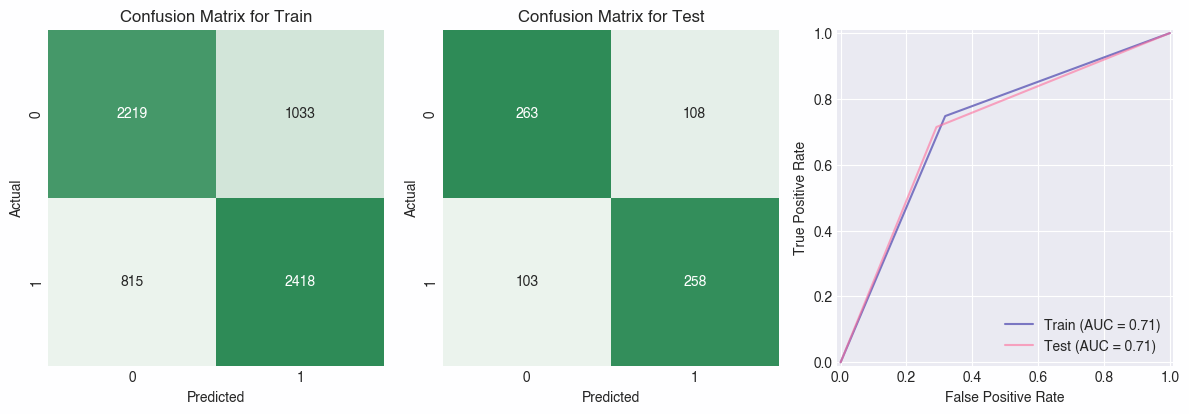

In [21]:
# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

### Evaluate model

In [ ]:
loaded_models["voting_classified"] = voting_classifier

In [ ]:
# error_compare_models function
em.error_compare_models(loaded_models, y_test, proba= True)

### Get best params from pickle file

In [ ]:
# List of paths to the pickle files you want to load
pickle_files = [
    '../models/xgb_final/xgb_5.pickle',
    '../models/RF_final/RF_final.pickle',
    '../models/SVC_final/best_svc_resnet.pkl'
]

# Dictionary to store loaded models
loaded_models = {}

# Load the selected pickle files
for file_path in pickle_files:
    with open(file_path, 'rb') as f:
        file_name = os.path.basename(file_path)
        model_name = os.path.splitext(file_name)[0]
        loaded_models[model_name] = pickle.load(f)

/Users/eockfen/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.2.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/eockfen/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/eockfen/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-packages/sklearn/base.py:376: Inco

In [ ]:
# List of paths to the pickle files 
pickle_files = [
    '../models/xgb_final/xgb_5.pickle',
    '../models/RF_final/RF_final.pickle',
    '../models/SVC_final/best_svc_resnet.pkl'
]

# Dictionary to store loaded models
loaded_models = {}

# Load the selected pickle files
for file_path in pickle_files:
    with open(file_path, 'rb') as f:
        file_name = os.path.basename(file_path)
        model_name = os.path.splitext(file_name)[0]
        loaded_models[model_name] = pickle.load(f)

# Check if the model has best parameters
if hasattr(loaded_models[best_svc_resnet.pkl], 'best_params_'):
    best_params = loaded_models[best_svc_resnet.pkl].best_params_
    print("Best Parameters:", best_params)
else:
    print("Model does not have best parameters.")

/Users/eockfen/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.2.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/eockfen/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/eockfen/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-packages/sklearn/base.py:376: Inco

NameError: name 'best_svc_resnet' is not defined

### Load models from pickle files

In [ ]:
# List of paths to the pickle files you want to load
pickle_files = [
    '../models/xgb_final/xgb_5.pickle',
    '../models/RF_final/RF_final.pickle',
    '../models/SVC_final/best_svc_resnet.pkl'
]

# Dictionary to store loaded models
loaded_models = {}

# Load the selected pickle files
for file_path in pickle_files:
    with open(file_path, 'rb') as f:
        file_name = os.path.basename(file_path)
        model_name = os.path.splitext(file_name)[0]
        loaded_models[model_name] = pickle.load(f)

xgb_pred = xgb_5.predict_proba(X_test[feat_xgb])
rf_pred= RF_final.predict_proba(X_test[feat_RF])
svc_pred = best_svc_resnet.predict_proba(X_test[feat_SVC])

finalpred = (pred1 + pred2 + pred3) / 3
finalpred = np.argmax(finalpred.round(0), axis = 1)
(y_test == finalpred).sum() / len(finalpred)


/Users/eockfen/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/eockfen/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.2.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/eockfen/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-packages/sklearn/base.py:376: Inco

### Averaging the predictions

In [ ]:
# List of paths to the pickle files you want to load
pickle_files = [
    '../models/xgb_final/xgb_5.pickle',
    '../models/RF_final/RF_final.pickle',
    '../models/SVC_final/best_svc_resnet.pkl'
]

# Dictionary to store loaded models
loaded_models = {}

# Load the selected pickle files
for file_path in pickle_files:
    with open(file_path, 'rb') as f:
        model_name = os.path.splitext(os.path.basename(file_path))[0]
        loaded_models[model_name] = pickle.load(f)

#fit each model on selected features
loaded_models['xgb_5'].fit(X_train[feat_xgb],y_train[feat_xgb])
loaded_models['RF_final'].fit(X_train[feat_RF],y_train[feat_RF])
loaded_models['best_svc_resnet'].fit(X_train[feat_SVC],y_train[feat_SVC])


# Make predictions for each model
xgb_pred = loaded_models['xgb_5'].predict_proba(X_test[feat_xgb])
rf_pred = loaded_models['RF_final'].predict_proba(X_test[feat_RF])
svc_pred = loaded_models['best_svc_resnet'].predict_proba(X_test[feat_SVC])

# Average the predictions
final_pred = (xgb_pred + rf_pred + svc_pred) / 3

# Convert probabilities to class labels
final_pred_labels = np.argmax(final_pred.round(0), axis=1)

/Users/eockfen/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/eockfen/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.2.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/eockfen/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-packages/sklearn/base.py:376: Inco

KeyError: "None of [Index(['sp_fix_count', 'sp_fix_duration_ms_var', 'sp_len_px_total',\n       'sp_saccade_amplitude_px_mean', 'sp_saccade_amplitude_px_var',\n       'sp_distance_to_centre_px_mean', 'sp_distance_to_centre_px_var',\n       'sp_distance_to_sp_mean_px_mean', 'sp_distance_to_sp_mean_px_var',\n       'dg_sal_first_fixation', 'dg_sal_sum', 'dg_sal_max',\n       'dg_sal_weighted_duration_sum', 'dg_sal_weighted_duration_mean',\n       'dg_sal_KLD', 'dg_sal_NSS', 'obj_t_abs_on_face', 'obj_t_rel_on_face',\n       'obj_t_abs_on_animate', 'obj_t_abs_on_inanimate',\n       'obj_t_abs_on_background', 'obj_t_rel_on_animate',\n       'obj_t_rel_on_inanimate', 'obj_t_rel_on_background'],\n      dtype='object', name='id')] are in the [index]"

In [ ]:
xgb_pred = xgb_5.predict_proba(X_test[feat_xgb])
rf_pred= RF_final.predict_proba(X_test[feat_RF])
svc_pred = best_svc_resnet.predict_proba(X_test[feat_SVC])

finalpred = (pred1 + pred2 + pred3) / 3
finalpred = np.argmax(finalpred.round(0), axis = 1)
(y_test == finalpred).sum() / len(finalpred)

### Use the voting classifier to predict 

In [ ]:
# Select common features
common_features = list(set(feat_xgb) & set(feat_RF) & set(feat_SVC))

# Filter the DataFrame to include only the common features
df_filtered = df[common_features]

# Create the voting classifier
voting_classifier = VotingClassifier(
    estimators=list(loaded_models.items()),
    voting='soft'  # 'soft' if models provide probabilities

)

# Fit the voting classifier
voting_classifier.fit(X_train, y_train)

# Predictions
predictions = voting_classifier.predict(X_test)

AttributeError: 'OneHotEncoder' object has no attribute 'feature_name_combiner'

In [ ]:
from sklearn.ensemble import VotingClassifier

model1 = LogisticRegression(random_state = RSEED)
model2 =  KNeighborsClassifier()
model3 = DecisionTreeClassifier(random_state = RSEED)

model = VotingClassifier(estimators = [('lr', model1), ('knn', model2), ('dt', model3)], voting = 'hard')
model.fit(X_train,y_train)
model.score(X_test,y_test)